## Методы оптимизации в машинном обучении
## Ширинбеков Руслан
## НПМбд-01-19

In [14]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import optimization
import oracles
import presubmit_tests 
from plot_trajectory_2d import plot_levels, plot_trajectory
from sklearn.datasets import load_svmlight_file

Проверка правильности реализации подсчета градиента и гессиана логистического оракула с помощью реализованных функций. 
Сгенерируем небольшую модельную выборку (матрицу A и вектор b) и сравним значения, выдаваемые методами grad и hess, с соответствующими разностными аппроксимациями в некоторой точке x.

In [15]:
A = np.array([[1, 1], [2, -3], [0, 6]])
b = np.array([1, 1, -1])
regcoef = 2
oracle = oracles.create_log_reg_oracle(A, b, regcoef)
f = lambda x: oracle.func(x)
x = np.array([1, 2])
print('Градиент через grad:', oracle.grad(x))
print('Градиент через grad_finite_diff:', oracles.grad_finite_diff(f, x))
print('Гессиан через hess:')
print(oracle.hess(x))
print('Гессиан через hess_finite_diff')
print(oracles.hess_finite_diff(f, x))

Градиент через grad: [1.32951552 6.96619288]
Градиент через grad_finite_diff: [1.32951552 6.96619278]
Гессиан через hess:
[[ 2.03860916 -0.02026653]
 [-0.02026653  2.06812073]]
Гессиан через hess_finite_diff
[[ 2.03861816 -0.02026823]
 [-0.02026823  2.06808792]]


Значения почти одинаковые

Проверяем тесты presubmit_tests.py.

In [16]:
presubmit_tests.test_python3()
presubmit_tests.test_QuadraticOracle()
presubmit_tests.test_log_reg_usual()
presubmit_tests.test_log_reg_oracle_calls()
presubmit_tests.test_grad_finite_diff_1()
presubmit_tests.test_grad_finite_diff_2()
presubmit_tests.test_hess_finite_diff_1()
presubmit_tests.test_hess_finite_diff_2()
presubmit_tests.test_line_search()
presubmit_tests.test_gd_basic()
presubmit_tests.test_newton_basic()
presubmit_tests.test_newton_1d()
presubmit_tests.test_newton_fail()

Сделано успешно
Сделано успешно
Сделано успешно
Сделано успешно


## Эксперимент: Траектория градиентного спуска на квадратичной функции

Как отличается поведение метода в зависимости от числа обусловленности функции, выбора начальной точки и стратегии выбора шага (константная стратегия, Армихо, Вульф)?

In [17]:
x0 = np.array([[3, 5], [1, -5], [-1, 0]])
methods = [{'method': 'Constant', 'c': 0.01}, 
           {'method': 'Armijo', 'alpha_0': 100.0, 'c1':0.5}, 
           {"method":'Wolfe', 'c1':0.1, 'c2':0.5, 'alpha_0':2.0}]

In [18]:
def graph(methods, x0, A, b):  
    oracle = oracles.QuadraticOracle(A, b)
    print('Число обусловленности =', np.linalg.norm(A) * np.linalg.norm(np.linalg.inv(A)))
    fig, ax = plt.subplots(len(methods), len(x0), figsize = (50,40))
    for i in range(len(methods)):
        for j in range(len(x0)):
            [x_star, msg, history] = optimization.gradient_descent(oracle, x0[j], line_search_options = methods[i], trace=True)
            plot_levels(oracle.func, ax[i][j])
            plot_trajectory(oracle.func, history['x'], ax[i][j])
            ax[i][j].set_title(methods[i]['method'] + '\nНачальная точка = ' + str(x0[j]) + '\nЧисло итераций = ' + str(len(history['x'])), fontsize = 30)

Число обусловленности = 2.5000000000000004


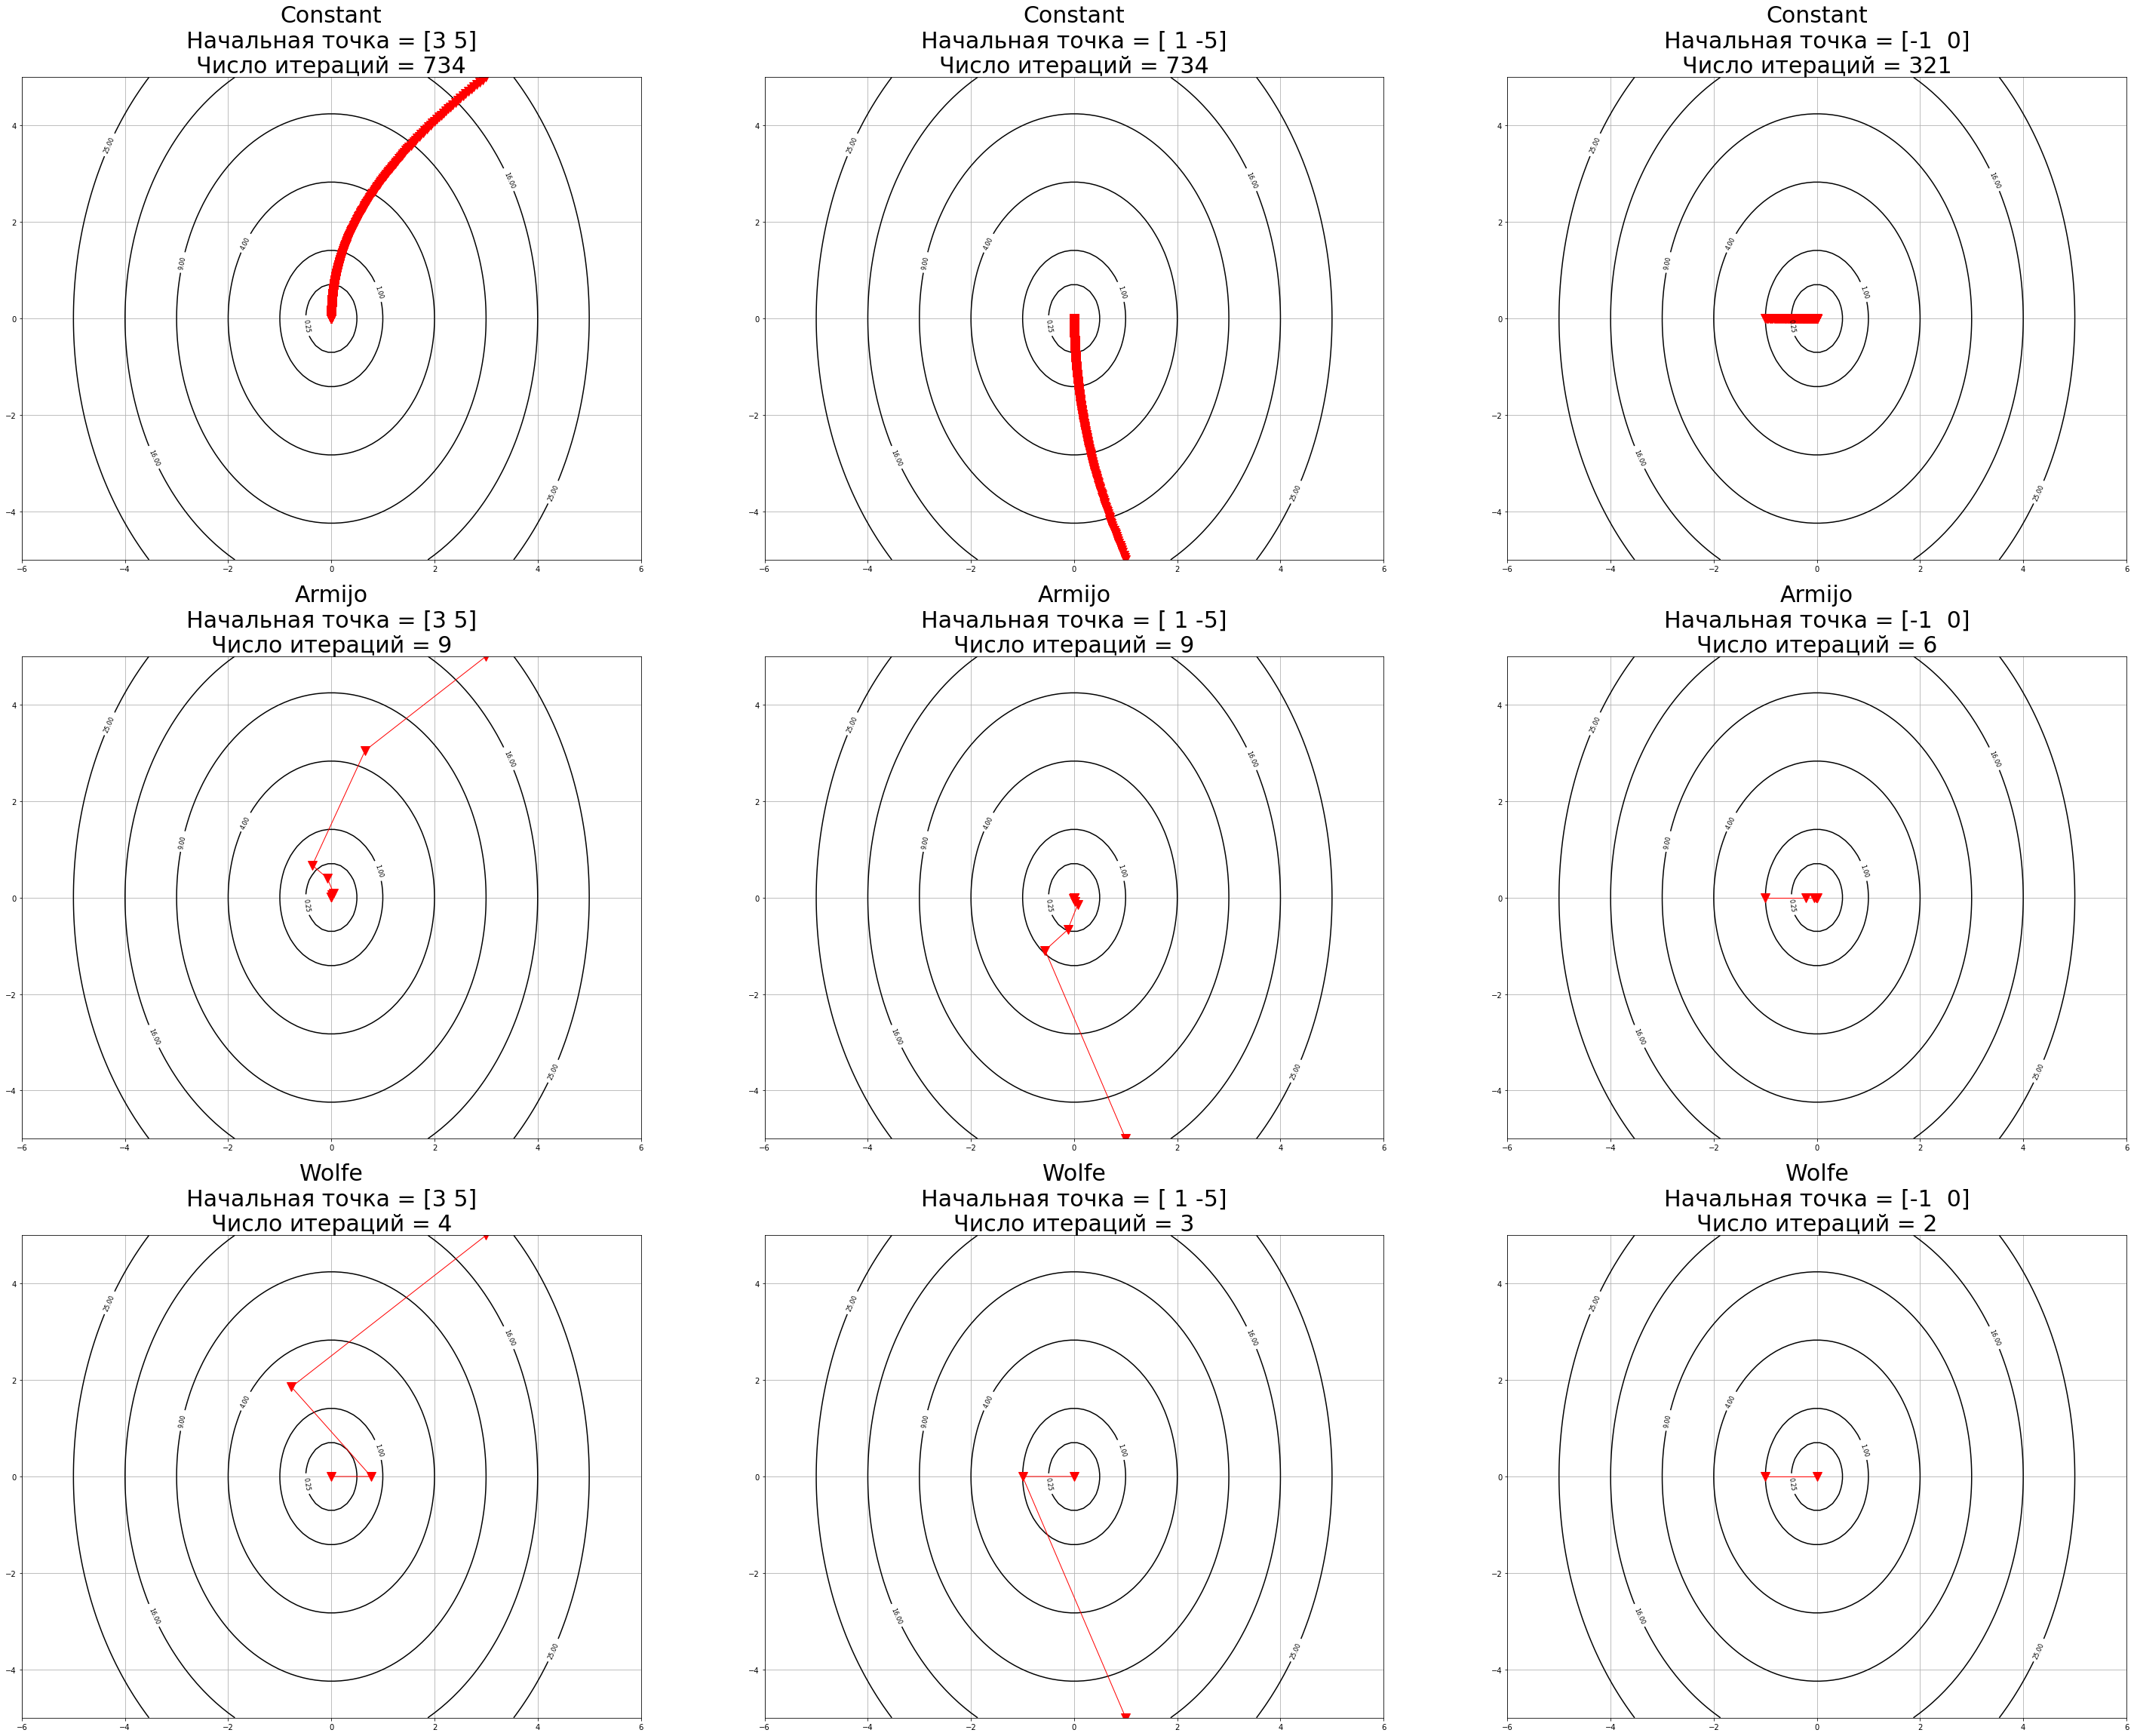

In [19]:
A1 = np.array([[2, 0], [0, 1]])
b1 = np.zeros(2)
graph(methods, x0, A1, b1)

Число обусловленности = 7.000000000000001


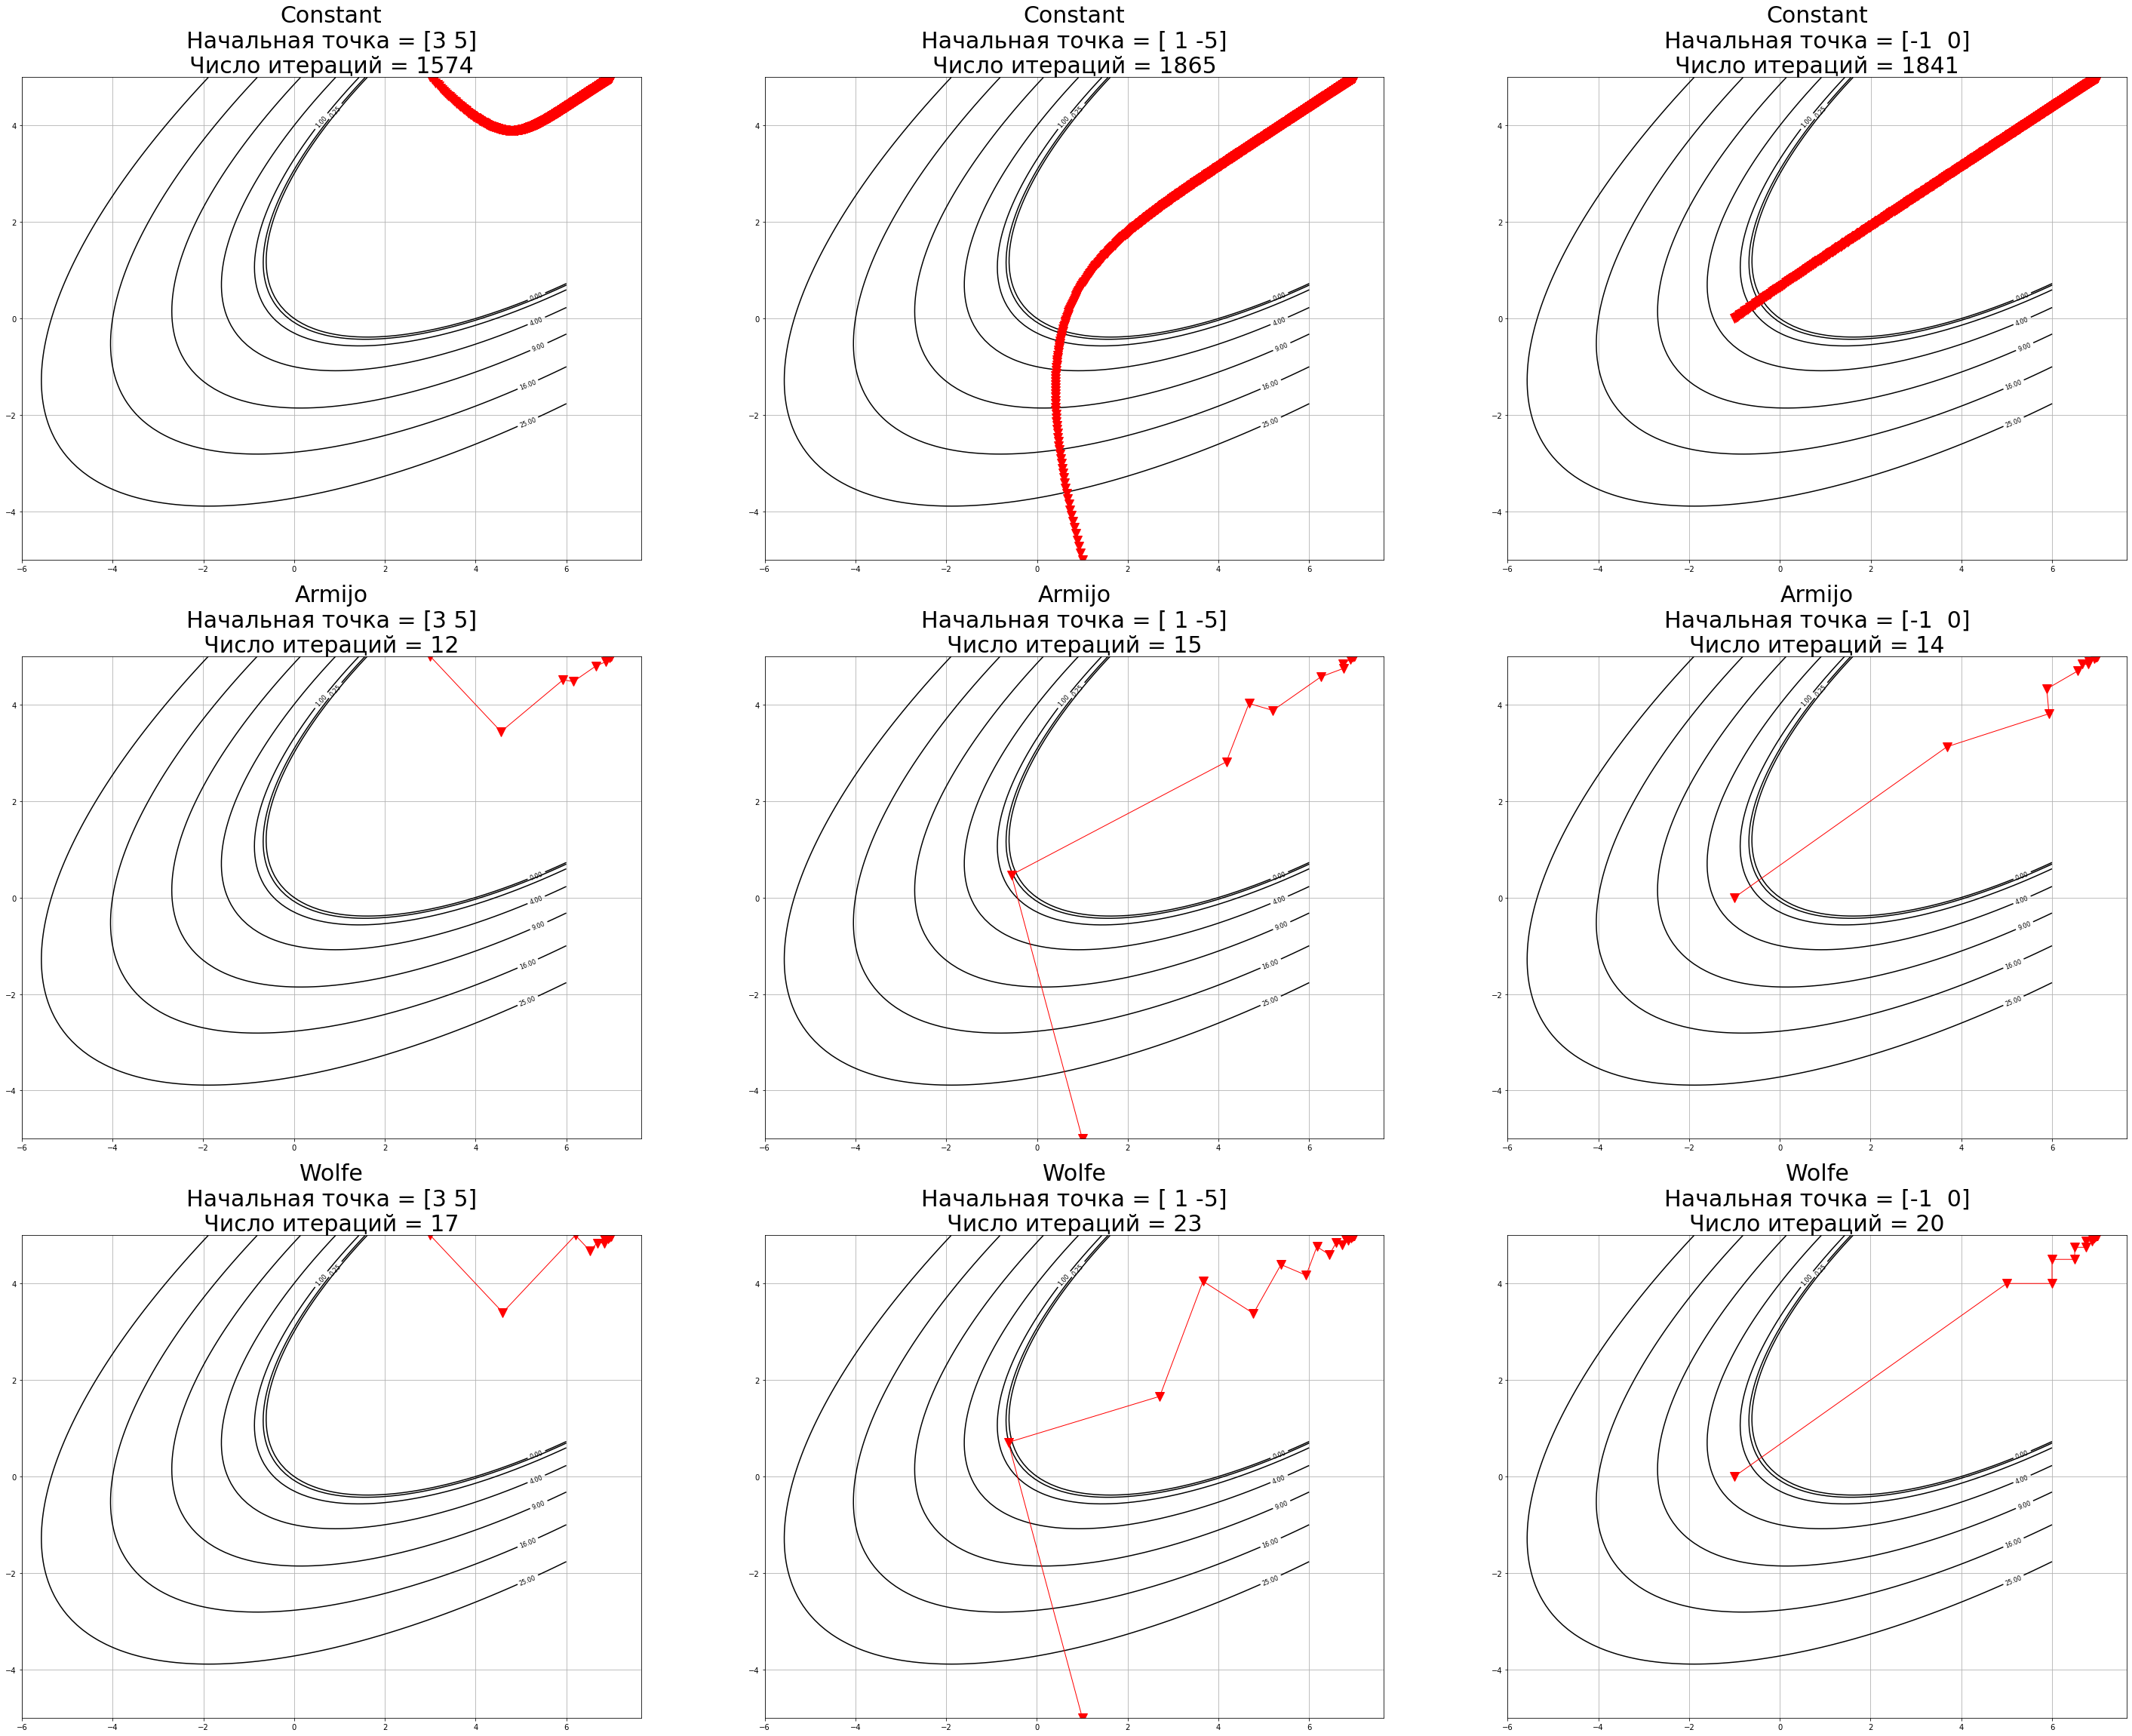

In [20]:
A2 = np.array([[1, -1], [-1, 2]])
b2 = np.array([2, 3])
graph(methods, x0, A2, b2)

С учётом точности и числа итераций, лучше всего себя показывает метод Вульфа. 
Число итераций зависит от выбора начальной точки.
При плохо обусловленной матрице есть немалое количество зигзагов на графике.

## Эксперимент: Зависимость числа итераций градиентного спуска от числа обусловленности и размерности пространства.

Исследуйте, как зависит число итераций, необходимое градиентному спуску для сходимости, от следующих двух параметров: 1) числа обусловленности k ≥ 1 оптимизируемой функции; 2) размерности пространства n оптимизируемых переменных

Для этого для заданных параметров n и k сгенерировать случайным образом квадратичную задачу размера n с числом обусловленности k и запустить на ней градиентный спуск.

In [21]:
k = np.arange(1, 101, 10)
methods = [{'method': 'Constant', 'c': 0.01}, 
           {'method': 'Armijo', 'alpha_0': 10.0, 'c1':0.5}, 
           {"method":'Wolfe', 'c1':1e-4, 'c2':0.9, 'alpha_0':4.0}]
options = [(10, 'r', 'n = 10'), (100, 'b', 'n = 100'), (1000, 'g', 'n = 1000')]

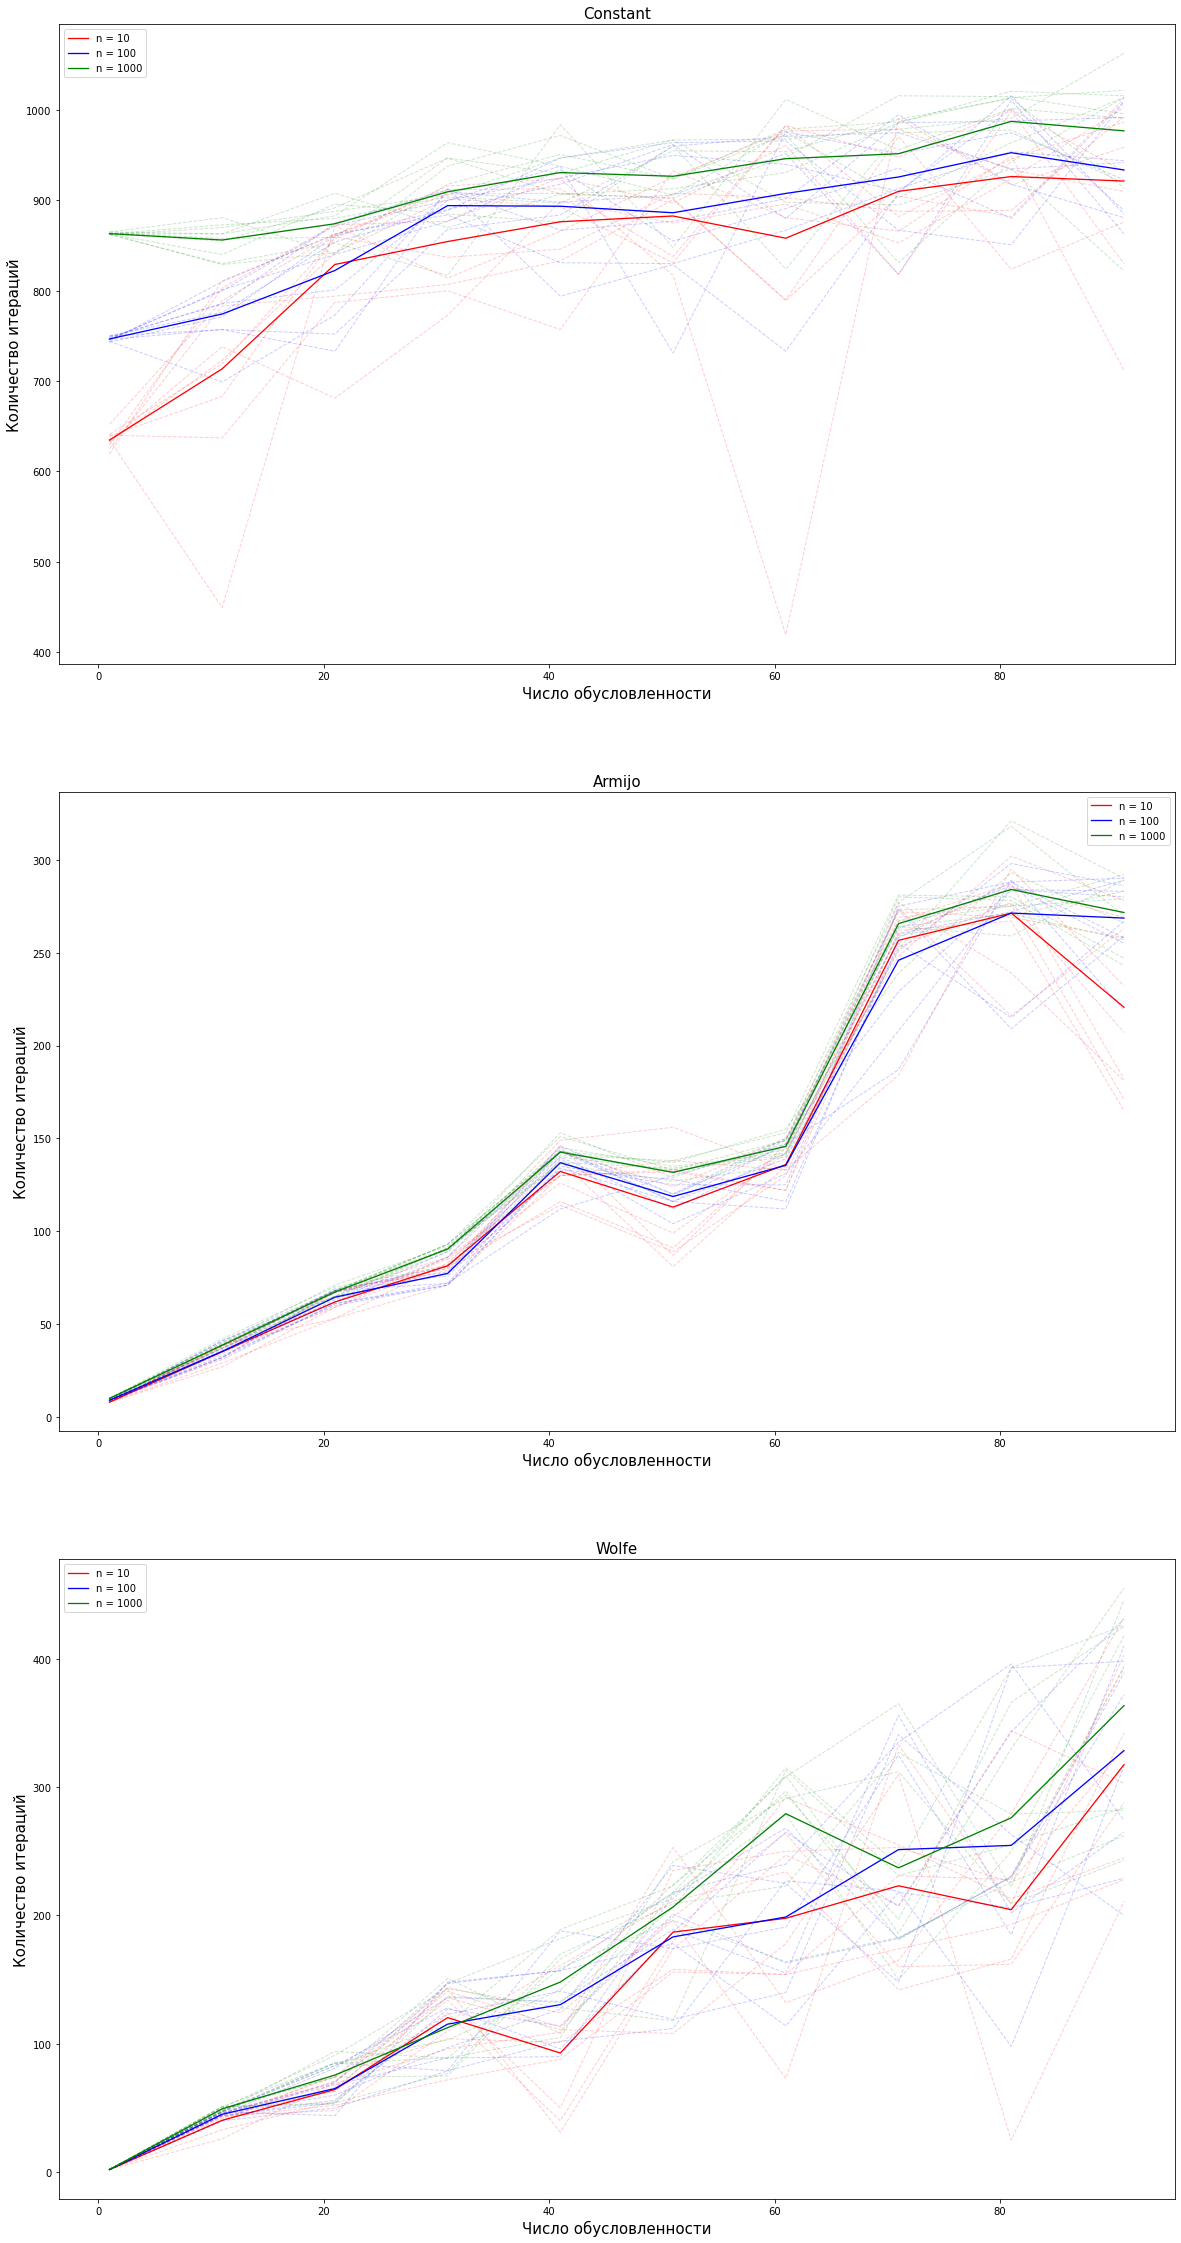

In [22]:
fig, ax = plt.subplots(3, 1, figsize=(20,40))
for i in range(len(methods)):
    for o in options:
        T = np.zeros(len(k))
        for j in range(10):
            t = []
            for k_ in k:
                diag = np.random.uniform(1, k_, o[0])
                diag[0] = 1
                diag[-1] = k_
                A = scipy.sparse.diags(diag)
                b = np.random.rand(o[0]) * k_
                oracle = oracles.QuadraticOracle(A, b)
                _, _, history = optimization.gradient_descent(oracle, np.zeros(o[0]), line_search_options = methods[i], trace=True)
                t.append(len(history['grad_norm']))
            T += np.array(t)
            ax[i].plot(k, t, o[1] + '--', linewidth=1, alpha=0.2)
        ax[i].plot(k, T/10, o[1], label = o[2], linewidth=1.3)
        ax[i].set_title('Метод: ' + str(methods[i]), fontsize = 15)
        ax[i].set_xlabel('Число обусловленности', fontsize = 15)
        ax[i].set_ylabel('Количество итераций', fontsize = 15)
        ax[i].set_title(methods[i]['method'], fontsize = 15)
        ax[i].legend()

Если растет число обусловленности, то растет и количество итераций.
Размерность не существенно влияет на количество итераций.

## Эксперимент: Сравнение методов градиентного спуска и Ньютона на реальной задаче логистической регрессии

Сравнить методы градиентного спуска и Ньютона на задаче обучения логистической регрессии на реальных данных.
В качестве реальных данных используйте следующие три набора с сайта LIBSVM3: w8a, gisette и real-sim. Коэффициент регуляризации взять стандартным образом: λ = 1/m. Параметры обоих методов взять равными параметрам по умолчанию. Начальную точку выбрать x0 = 0. 

Построить графики сходимости следующих двух видов:

(а) Зависимость значения функции от реального времени работы метода

(б) Зависимость относительного квадрата нормы градиента 
 (в логарифмической шкале) против реального времени работы.

In [23]:
def visualize(file):
    fig, ax = plt.subplots(1, 2, figsize=(20,10))
    A, b = load_svmlight_file(file)
    lambda_ = 1 / len(b)
    oracle = oracles.create_log_reg_oracle(A, b, lambda_)
 
    _, _, history_gd = optimization.gradient_descent(oracle, np.zeros(A.shape[1]), trace=True)
    ax[0].plot(history_gd['time'], history_gd['func'], label='Градиентный спуск')
    _, _, history_n = optimization.newton(oracle, np.zeros(A.shape[1]), trace=True)
    ax[0].plot(history_n['time'], history_n['func'], label='Метод Ньютона')   
    ax[0].set_xlabel('Время работы метода')
    ax[0].set_ylabel('Значение функции')
    ax[0].legend()

    ax[1].plot(history_gd['time'], np.array(history_gd['grad_norm']) ** 2 / history_gd['grad_norm'][0] ** 2, label="Градиентный спуск")
    ax[1].plot(history_n['time'], np.array(history_n['grad_norm']) ** 2 / history_n['grad_norm'][0] ** 2, label="Метод Ньютона")   
    ax[1].set_yscale('log')
    ax[1].set_xlabel('Время работы метода')
    ax[1].set_ylabel('Относительный квадрат нормы градиента')
    ax[1].legend()

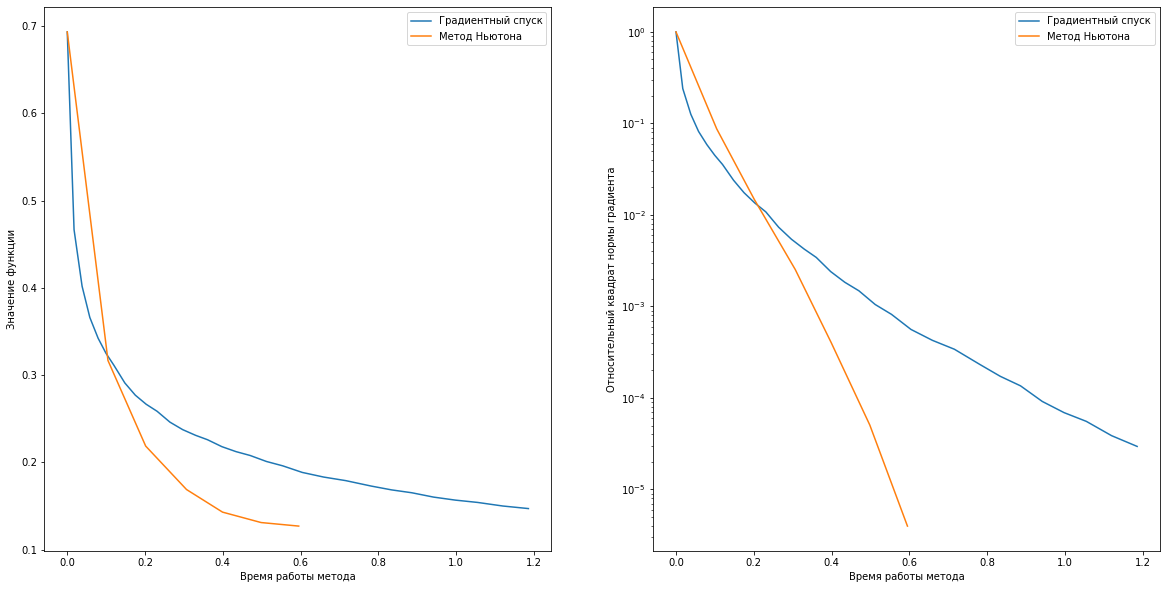

In [24]:
visualize('данные/w8a.txt')

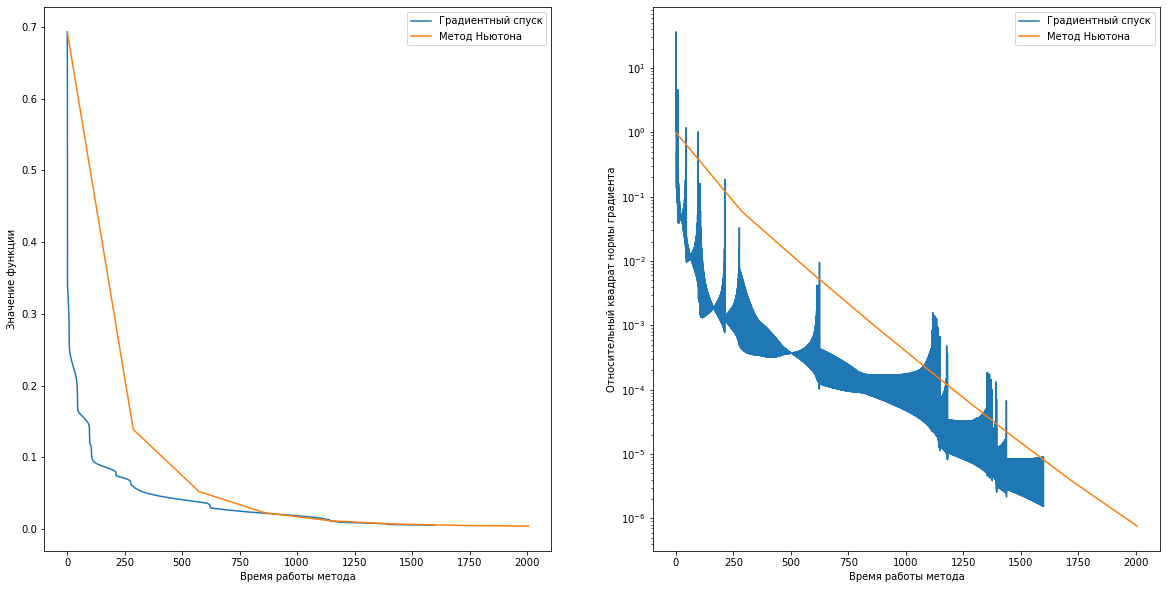

In [25]:
visualize('данные/gisette_scale.bz2') 

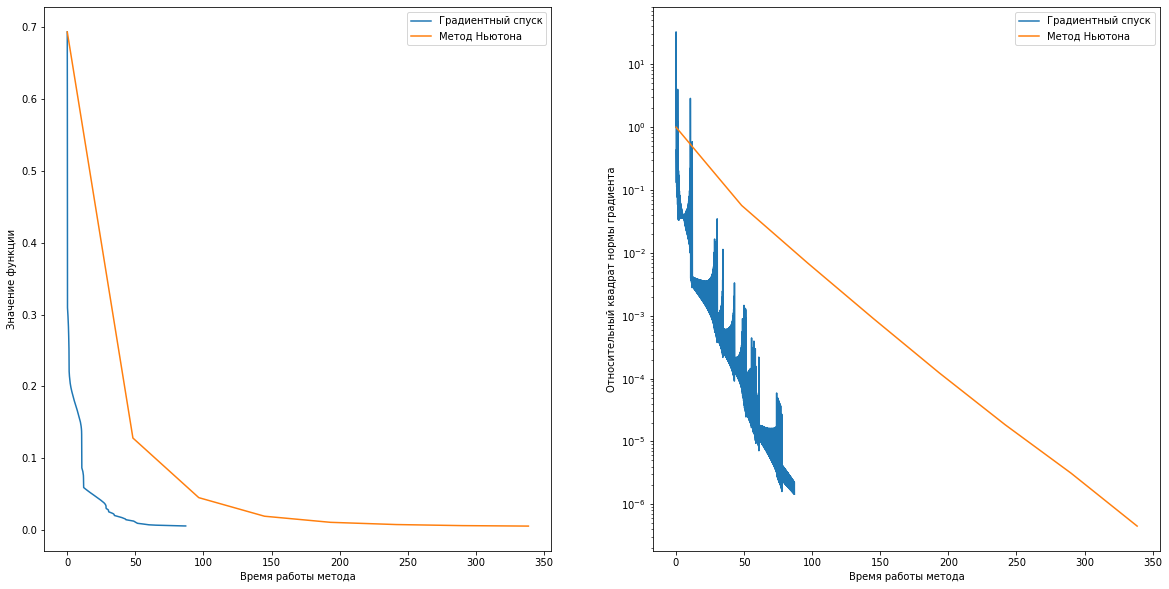

In [26]:
visualize('данные/gisette_scale.t.bz2')